In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [8]:
model = models.vgg19(pretrained=True).features

In [9]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        # The first number x in convx_y gets added by 1 after it has gone
        # through a maxpool, and the second y if we have several conv layers
        # in between a max pool. These strings (0, 5, 10, ..) then correspond
        # to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 mentioned in NST paper
        self.chosen_features = ["0", "5", "10", "19", "28"]

        # We don't need to run anything further than conv5_1 (the 28th module in vgg)
        # Since remember, we dont actually care about the output of VGG: the only thing
        # that is modified is the generated image (i.e, the input).
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        # Go through each layer in model, if the layer is in the chosen_features,
        # store it in features. At the end we'll just return all the activations
        # for the specific layers we have in chosen_features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [19]:
def load_image(image_name):
    image = Image.open(image_name)
    image = transformations(image).unsqueeze(0)
    return image.to(device)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

In [14]:
transformations = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [16]:
import requests
from PIL import Image
from io import BytesIO

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/330px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

img.show()         # Hiển thị ảnh
img.save("style_image.jpg")  # Lưu ảnh ra file

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpf65bb9r1.PNG'


In [21]:
original_img = load_image("/kaggle/input/dogs-and-cats/cats_and_dogs_filtered/train/cats/cat.104.jpg")
style_img = load_image("style_image.jpg")

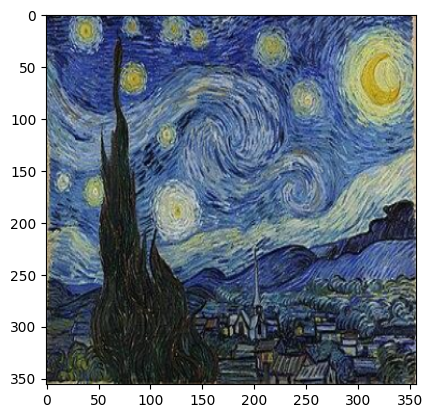

In [33]:
import matplotlib.pyplot as plt

plt.imshow(style_img.squeeze(0).permute(1, 2, 0).cpu().numpy())

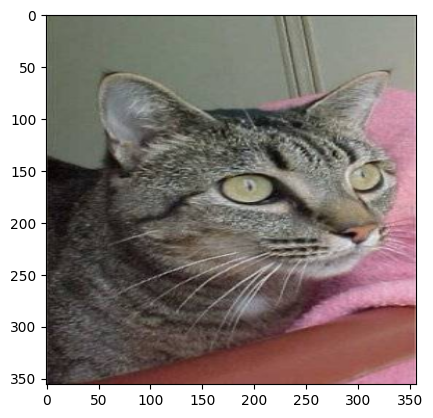

In [38]:
plt.imshow(original_img.squeeze(0).permute(1, 2, 0).cpu().numpy())

In [34]:
generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, "generated.png")

tensor(578510.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28112.7988, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13032.2695, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5339.5151, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2279.5286, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1443.4465, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1132.8252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(949.5371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(821.0840, device='cuda:0', grad_fn=<AddBackward0>)
tensor(725.0391, device='cuda:0', grad_fn=<AddBackward0>)
tensor(650.8431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(592.7712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(545.8593, device='cuda:0', grad_fn=<AddBackward0>)
tensor(507.2398, device='cuda:0', grad_fn=<AddBackward0>)
tensor(474.7537, device='cuda:0', grad_fn=<AddBackward0>)
tensor(447.0603, device='cuda:0', grad_fn=<AddBackward0>)
tensor(422.9820, device='cuda:0', grad_fn=<AddBackward0>)
ten

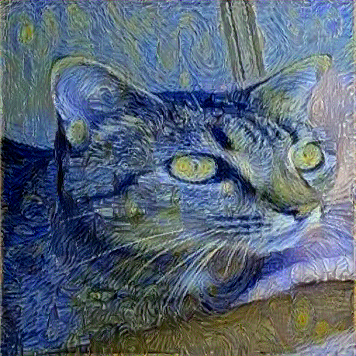

In [37]:
Image.open('/kaggle/working/generated.png')